In [83]:
import requests
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image, display, HTML
import pandas as pd
import json
import geopandas as gpd
from io import StringIO
from csv import reader
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
from shapely.geometry import Point
from patsy import dmatrices
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [46]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Create paramters
crime_params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01T00:00:00.000\' and \'2021-07-01T00:00:00.000\'',
    '$limit': 2000   

}

# Generate response
response = requests.get('https://data.nashville.gov/resource/2u6v-ujjs.geojson', params = crime_params)

# Convert json object to geopandas DataFrame, drop duplicates
crime = (
    gpd.read_file(StringIO(response.text))
    .drop_duplicates(subset = 'incident_number')
    .reset_index(drop = True)
)

# Read in census tract shapefile
tract = gpd.read_file('data/tl_2019_47_tract.shp') 

# Clean up shapefile, covert to proper geometry
tract = tract[tract['COUNTYFP'] == '037']
tract = tract.reset_index(drop = True)
tract = tract.rename(columns = {'TRACTCE': 'tract'})

# Spatial join burglaries and census tract tables, keep relevant columns
crimeBYtract = gpd.sjoin(tract, crime, how='left', op ='contains')
crimeBYtract = crimeBYtract[['incident_number', 'incident_reported', 'geometry', 'tract']]
crimeBYtract['tract'] = crimeBYtract['tract'].astype(str)

# Tract with highest number of burglaries
print(crimeBYtract.groupby('tract')['incident_number'].nunique().nlargest(1))


In [63]:
# Read in census tract shapefile
tract = (gpd.read_file('data/tl_2019_47_tract.shp'))

# Clean up shapefile, covert to proper geometry
tract = tract[tract['COUNTYFP'] == '037']
tract = tract.rename(columns = {'TRACTCE': 'tract'})
#tract = tract.to_crs('EPSG:4326')

# Spatial join burglaries and census tract tables, keep relevant columns
crimeBYtract = gpd.sjoin(crime, tract, how='right', op ='within')
crimeBYtract = crimeBYtract[['incident_number', 'incident_reported', 'geometry', 'tract']]
crimeBYtract['tract'] = crimeBYtract['tract'].astype(str)

# Tract with highest number of burglaries
crimeBYtract.groupby('tract')['incident_number'].nunique().nlargest(1)

tract
016300    53
Name: incident_number, dtype: int64

In [4]:
# Load API key for American Community Survey API

with open ('data/census.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [5]:
# Create endpoint, parameters, and generate response for population data

pop_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}

pop_response = requests.get('https://api.census.gov/data/2019/acs/acs5', params = pop_params)

# Convert response to pandas DataFrame and clean up

pop = pop_response.json()
pop = pd.DataFrame(data = pop[1:], columns = pop[0])
pop['B01001_001E'] = pop['B01001_001E'].astype(int)
pop = pop.rename(columns = {'B01001_001E': 'population'})

In [6]:
# Create parameters and generate response for income data

inc_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}

inc_response = requests.get('https://api.census.gov/data/2019/acs/acs5/subject', params = inc_params)

# Convert response to pandas DataFrame and clean up

inc = inc_response.json()
inc = pd.DataFrame(data = inc[1:], columns = inc[0])
inc = inc.rename(columns={'S1901_C01_012E': 'median_income'})
inc['median_income'] = inc['median_income'].astype(int)

In [7]:
# Merge all into one DataFrame and clean up

df_merge = [crimeBYtract, pop, inc]
crime_pop_inc = reduce(lambda left, right: pd.merge(left, right, on ='tract'), df_merge)
#crime_pop_inc.geometry.to_crs('EPSG:4326')
crime_pop_inc = crime_pop_inc[['incident_number', 'incident_reported', 'tract', 'median_income', 'population', 'geometry']]
crime_pop_inc['median_income'] = crime_pop_inc['median_income'].replace(-666666666, np.nan)
crime_pop_inc['population'] = crime_pop_inc['population'].fillna(0)
crime_pop_inc['tract'] = crime_pop_inc['tract'].astype(str)

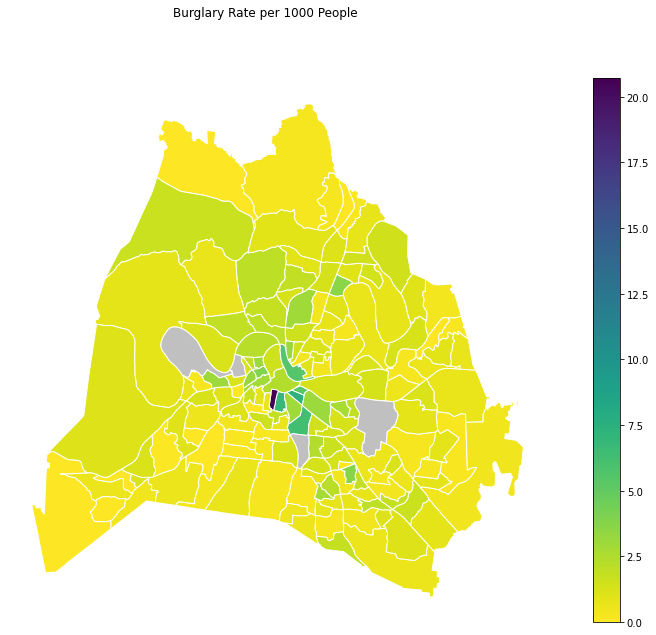

In [80]:
# Create DataFrame for choropleth

choropleth_data = pd.DataFrame(crime_pop_inc.groupby(['tract', 'population', 'median_income'], as_index = False)['incident_number'].nunique())
choropleth_data['incident_rate_per_1000'] = choropleth_data['incident_number'] / choropleth_data['population'] * 1000
choropleth_data = pd.merge(left = tract, right = choropleth_data, how = 'left')
choropleth_data = choropleth_data[['tract', 'population', 'incident_number', 'incident_rate_per_1000', 'geometry', 'median_income']]
choropleth_data = choropleth_data.replace([np.inf, -np.inf, -666666666], np.nan)
choropleth_data['population'] = choropleth_data['population'].replace(0, np.nan)

# Plot DataFrame as choropleth

fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Burglary Rate per 1000 People')
choropleth_data.plot(
    column = 'incident_rate_per_1000',
    cmap = 'viridis_r',
    edgecolor = 'white',
    missing_kwds = {'color': 'silver'},
    legend = 'true',
    ax = ax
)

ax.axis('off');

In [ ]:
fig = px.choropleth(
    choropleth_data.to_json,
    color_continuous_scale='viridis_r',
    geojson='geometry',             
    locationmode = 'USA-states',
    scope='usa',
    hover_name='state',
    hover_data='text', # I've tried just text as well, but not working
    # I've also tried covtrack_states_hist_df['text'] and covtrack_states_hist_df.text but none of them worked
    animation_frame='date',
    title="Daily New COVID-19 Confirmed Cases",
    color_continuous_scale= color_scale, 

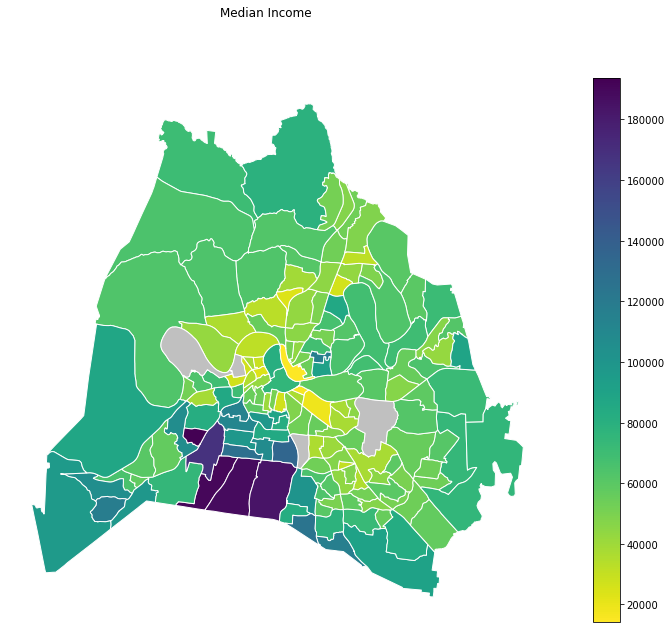

In [43]:
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Median Income')

choropleth_data.plot(
    column = 'median_income',
    cmap = 'viridis_r',
    edgecolor = 'white',
    missing_kwds = {'color': 'silver'},
    legend = 'true',
    ax = ax
)

ax.axis('off');

In [117]:
choropleth_pop_density = choropleth_data.copy()
choropleth_pop_density = choropleth_pop_density.to_crs({'init': 'epsg:32633'})
choropleth_pop_density["area"] = choropleth_pop_density['geometry'].area/ 10**6
choropleth_pop_density['pop_per_sq_km'] = choropleth_pop_density['population'] / choropleth_pop_density['area']
choropleth_pop_density = choropleth_pop_density[['tract', 'pop_per_sq_km']]                       
choropleth_pop_density = pd.merge(choropleth_data, choropleth_pop_density, how = 'left', on = 'tract' )

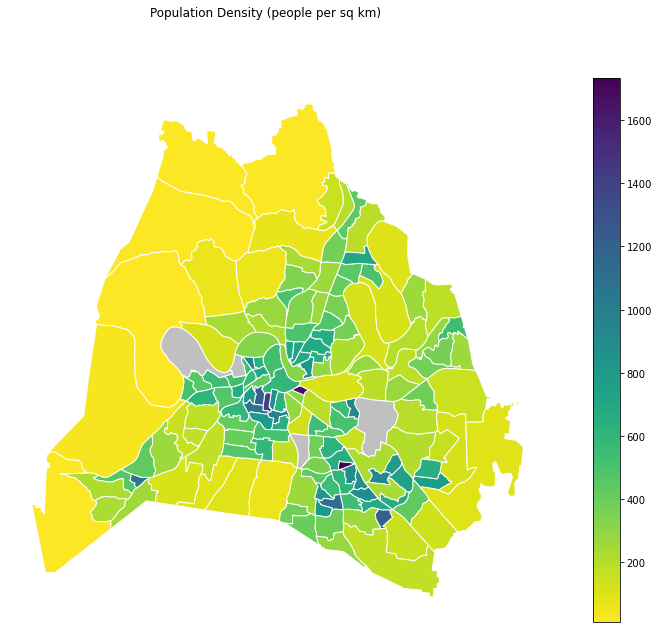

In [118]:
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Population Density (people per sq km)')
choropleth_pop_density.plot(
    column = 'pop_per_sq_km',
    cmap = 'viridis_r',
    edgecolor = 'white',
    missing_kwds = {'color': 'silver'},
    legend = 'true',
    ax = ax
)

ax.axis('off');

In [76]:
pd.set_option('display.max_rows', None)
choropleth_pop_density[['tract', 'pop_per_sq_km']].sort_values('pop_per_sq_km', ascending=False)

,tract,pop_per_sq_km
113,019005,1733.130797
88,014800,1645.281305
91,016400,1415.532867
153,019118,1207.156830
94,016500,1197.498487
101,019105,1114.618089
24,018410,1064.678842
99,016800,1057.193737
117,017000,981.595876
74,013800,942.612236


In [50]:
# 5(a)  Build a "base model" - a Poisson regression model with just an intercept term with target variable 
#       the rate of burglaries per census tract. (Offset using the [log of the] population so that we are 
#       looking at the rate of burglaries per population instead of the number of burglaries.)

# Create necessary log and intercept columns

model_data = choropleth_pop_density.copy()
model_data['intercept'] = 1
model_data['log_population'] = np.log(model_data['population'])
model_data['log_median_income'] = np.log(model_data['median_income'])
model_data['log_pop_density'] = np.log(model_data['pop_per_sq_km'])
model_data = model_data.dropna()

untrained_poisson_model = sm.GLM(endog = model_data['incident_number'],
                                 exog = model_data['intercept'],
                                 offset = model_data['log_population'],
                                 family = sm.families.Poisson()).fit()
                                
print('Untrained Poisson Model')
display(untrained_poisson_model.summary())

Untrained Poisson Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -605.45
Date:                Tue, 12 Oct 2021   Deviance:                       728.78
Time:                        13:18:20   Pearson chi2:                 1.42e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.7251      0.035   -192.813      0.000      -6.793      -6.657
==============================================================================
"""

In [52]:
# Create training and testing data sets

mask = np.random.rand(len(model_data)) < 0.7
model_train = model_data[mask]
model_test = model_data[~mask]


# Create regression expressions defining both dependent and independent variables

expr_inc = """incident_number ~ log_median_income"""
expr_pop = """incident_number ~ log_population"""
expr_dens = """incident_number ~ log_pop_density"""

# Set up matrices for training

y_train_inc, X_train_inc = dmatrices(expr_inc, model_train, return_type = 'dataframe')
y_test_inc, X_test_inc = dmatrices(expr_inc, model_test, return_type = 'dataframe')
y_train_pop, X_train_pop = dmatrices(expr_pop, model_train, return_type = 'dataframe')
y_test_pop, X_test_pop = dmatrices(expr_pop, model_test, return_type = 'dataframe')
y_train_dens, X_train_dens = dmatrices(expr_dens, model_train, return_type = 'dataframe')
y_test_dens, X_test_dens = dmatrices(expr_dens, model_test, return_type = 'dataframe')

# Train model and show summary

poisson_training_inc = sm.GLM(y_train_inc, X_train_inc, family = sm.families.Poisson()).fit()
poisson_training_pop = sm.GLM(y_train_pop, X_train_pop, family = sm.families.Poisson()).fit()
poisson_training_dens = sm.GLM(y_train_dens, X_train_dens, family = sm.families.Poisson()).fit()
print('Training data set length='+str(len(model_train)))
print('Testing data set length='+str(len(model_test)))
print('')
print('Trained Poisson Model - Median Income Predictor')
display(poisson_training_inc.summary())

Training data set length=115
Testing data set length=42

Trained Poisson Model - Median Income Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -402.95
Date:                Tue, 12 Oct 2021   Deviance:                       454.33
Time:                        13:22:12   Pearson chi2:                     710.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5311
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.7030      0.942     11.357      0.000       8.856      12.550
log_median_income    -0.8292      0.087     -9.503      0.000      -1.000      -0.658
=====================================================================================
"""

In [53]:
print('Training data set length='+str(len(model_train)))
print('Testing data set length='+str(len(model_test)))
print('')
print('Trained Poisson Model - Population Predictor')
display(poisson_training_pop.summary())

Training data set length=115
Testing data set length=42

Trained Poisson Model - Population Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -442.23
Date:                Tue, 12 Oct 2021   Deviance:                       532.89
Time:                        13:23:03   Pearson chi2:                     861.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07152
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7295      0.834     -0.874      0.382      -2.365       0.906
log_population     0.2898      0.100      2.905      0.004       0.094       0.485
==================================================================================
"""

In [64]:
print('Training data set length='+str(len(model_train)))
print('Testing data set length='+str(len(model_test)))
print('')
print('Trained Poisson Model - Population Density Predictor')
display(poisson_training_dens.summary())

Training data set length=115
Testing data set length=42

Trained Poisson Model - Population Density Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -417.64
Date:                Tue, 12 Oct 2021   Deviance:                       483.72
Time:                        13:31:01   Pearson chi2:                     646.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3946
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5766      0.325     -1.773      0.076      -1.214       0.061
log_pop_density     0.3783      0.053      7.153      0.000       0.275       0.482
===================================================================================
"""

In [55]:
# 5(c) Finally, try out a negative binomial model.

# Add the λ vector as a new column to the trained data set 
# Add another column that derives the auxillary Ordinary Least Squares Regression OLSR values 

model_train['BB_LAMBDA_inc'] = poisson_training_inc.mu
model_train['BB_LAMBDA_pop'] = poisson_training_pop.mu
model_train['BB_LAMBDA_dens'] = poisson_training_dens.mu
model_train['AUX_OLS_DEP_inc'] = model_train.apply(lambda x: ((x['incident_number'] - x['BB_LAMBDA_inc']) **2\
                                                          - x['BB_LAMBDA_inc']) / x['BB_LAMBDA_inc'], axis=1)
model_train['AUX_OLS_DEP_pop'] = model_train.apply(lambda x: ((x['incident_number'] - x['BB_LAMBDA_pop']) **2\
                                                          - x['BB_LAMBDA_pop']) / x['BB_LAMBDA_pop'], axis=1)
model_train['AUX_OLS_DEP_dens'] = model_train.apply(lambda x: ((x['incident_number'] - x['BB_LAMBDA_dens']) **2\
                                                          - x['BB_LAMBDA_dens']) / x['BB_LAMBDA_dens'], axis=1)

# Set regression expression where OLS values are the dependent variable and λ vector is the regression variable.

ols_expr_inc = """AUX_OLS_DEP_inc ~ BB_LAMBDA_inc - 1"""
ols_expr_pop = """AUX_OLS_DEP_pop ~ BB_LAMBDA_pop - 1"""
ols_expr_dens = """AUX_OLS_DEP_dens ~ BB_LAMBDA_dens - 1"""

# Configure and fit the OLSR model

aux_olsr_results_inc = smf.ols(ols_expr_inc, model_train).fit()
aux_olsr_results_pop = smf.ols(ols_expr_pop, model_train).fit()
aux_olsr_results_dens = smf.ols(ols_expr_dens, model_train).fit()

# Supply the value of alpha found in the OLSR model, train the model, show summary

nb2_training_inc = sm.GLM(y_train_inc, X_train_inc, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results_inc.params[0])).fit()
nb2_training_pop = sm.GLM(y_train_pop, X_train_pop, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results_pop.params[0])).fit()
nb2_training_dens = sm.GLM(y_train_dens, X_train_dens, family= sm.families.NegativeBinomial\
                              (alpha = aux_olsr_results_dens.params[0])).fit()
print('Trained Negative Binomal Model - Median Income Predictor')
display(nb2_training_inc.summary())

Trained Negative Binomal Model - Median Income Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -308.76
Date:                Tue, 12 Oct 2021   Deviance:                       90.943
Time:                        13:24:22   Pearson chi2:                     133.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1283
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.0066      2.377      4.631      0.000       6.348      15.665
log_median_income    -0.8571      0.217     -3.943      0.000      -1.283      -0.431
=====================================================================================
"""

In [56]:
print('Trained Negative Binomal Model - Population Predictor')
display(nb2_training_pop.summary())

Trained Negative Binomal Model - Population Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -319.70
Date:                Tue, 12 Oct 2021   Deviance:                       86.581
Time:                        13:25:22   Pearson chi2:                     131.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.009282
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3827      2.149     -0.178      0.859      -4.594       3.829
log_population     0.2481      0.258      0.961      0.336      -0.258       0.754
==================================================================================
"""

In [57]:
print('Trained Negative Binomal Model - Population Density Predictor')
display(nb2_training_dens.summary())

Trained Negative Binomal Model - Population Density Predictor


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  115
Model:                            GLM   Df Residuals:                      113
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -312.73
Date:                Tue, 12 Oct 2021   Deviance:                       85.581
Time:                        13:25:24   Pearson chi2:                     94.9
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09054
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.7185      0.695     -1.034      0.301      -2.081       0.644
log_pop_density     0.4020      0.116      3.452      0.001       0.174       0.630
===================================================================================
"""

In [58]:
print('Untrained Poisson Model AIC: ' + str(untrained_poisson_model.aic))
print('')
print('Trained Poisson Model AIC - Median Income Predictor: ' + str(poisson_training_inc.aic))
print('')
print('Trained Poisson Model AIC - Population Predictor: ' + str(poisson_training_pop.aic))
print('')
print('Trained Poisson Model AIC - Population Density Predictor: ' + str(poisson_training_dens.aic))
print('')
print('Trained Negative Binomial AIC - Median Income Predictor: ' + str(nb2_training_inc.aic))
print('')
print('Trained Negative Binomial AIC - Population Predictor: ' + str(nb2_training_pop.aic))
print('')
print('Trained Negative Binomial AIC - Population Density Predictor: ' + str(nb2_training_dens.aic))

Untrained Poisson Model AIC: 1212.9082531097533

Trained Poisson Model AIC - Median Income Predictor: 809.8984549672952

Trained Poisson Model AIC - Population Predictor: 888.4620153262717

Trained Poisson Model AIC - Population Density Predictor: 839.2899193710755

Trained Negative Binomial AIC - Median Income Predictor: 621.5162306916402

Trained Negative Binomial AIC - Population Predictor: 643.406027056183

Trained Negative Binomial AIC - Population Density Predictor: 629.4538875513423


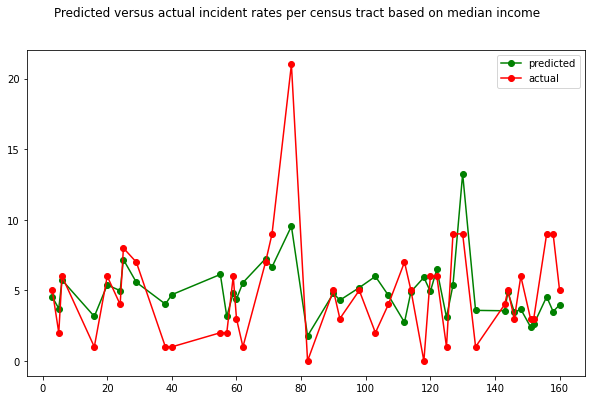

In [59]:
nb2_predictions_inc = nb2_training_inc.get_prediction(X_test_inc)
nb2_predictions_pop = nb2_training_pop.get_prediction(X_test_pop)
nb2_predictions_dens = nb2_training_dens.get_prediction(X_test_dens)
predictions_summary_frame_inc = nb2_predictions_inc.summary_frame()
predictions_summary_frame_pop = nb2_predictions_pop.summary_frame()
predictions_summary_frame_dens = nb2_predictions_dens.summary_frame()
predicted_counts_inc = predictions_summary_frame_inc['mean']
predicted_counts_pop = predictions_summary_frame_pop['mean']
predicted_counts_dens = predictions_summary_frame_dens['mean']
actual_counts_inc = y_test_inc['incident_number']
actual_counts_pop = y_test_pop['incident_number']
actual_counts_dens = y_test_dens['incident_number']


fig_inc = plt.figure(figsize = (10,6))
fig_inc.suptitle('Predicted versus actual incident rates per census tract based on median income')
predicted_inc = plt.plot(X_test_inc.index, predicted_counts_inc, 'go-', label='Predicted counts')
actual_inc = plt.plot(X_test_inc.index, actual_counts_inc, 'ro-', label='Actual counts')
plt.legend(labels = ['predicted', 'actual'])
plt.show()

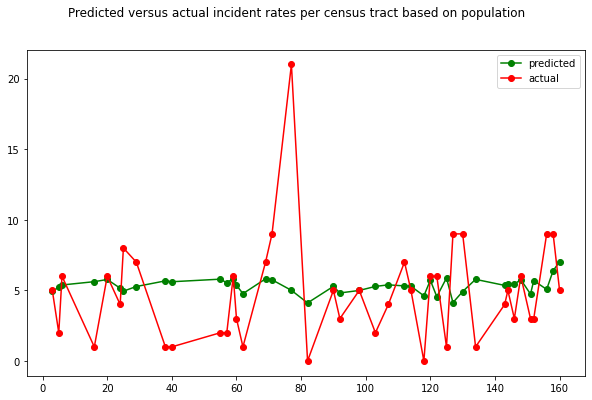

In [60]:
fig_pop = plt.figure(figsize = (10,6))
fig_pop.suptitle('Predicted versus actual incident rates per census tract based on population')
predicted_pop = plt.plot(X_test_pop.index, predicted_counts_pop, 'go-', label='Predicted counts')
actual_pop = plt.plot(X_test_pop.index, actual_counts_pop, 'ro-', label='Actual counts')
plt.legend(labels = ['predicted', 'actual'])
plt.show()

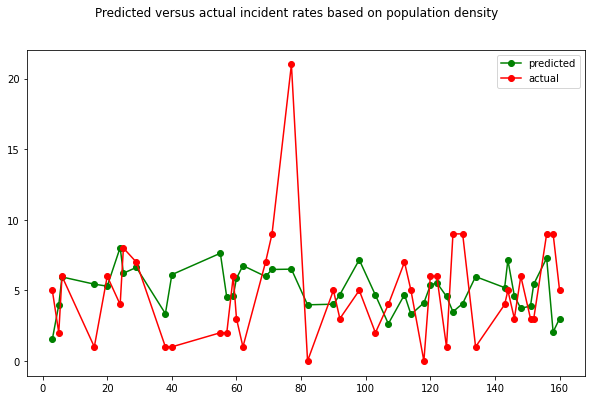

In [61]:
fig_dens = plt.figure(figsize = (10,6))
fig_dens.suptitle('Predicted versus actual incident rates based on population density')
predicted_dens = plt.plot(X_test_dens.index, predicted_counts_dens, 'go-', label='Predicted counts')
actual_dens = plt.plot(X_test_dens.index, actual_counts_dens, 'ro-', label='Actual counts')
plt.legend(labels = ['predicted', 'actual'])
plt.show()

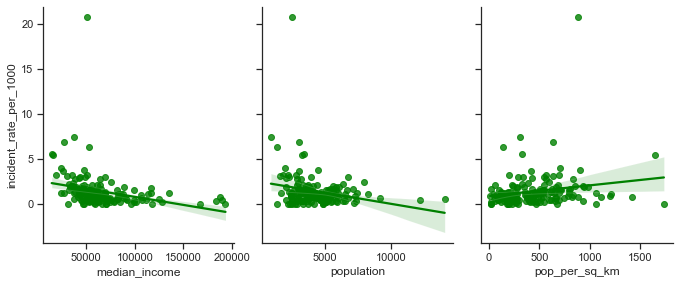

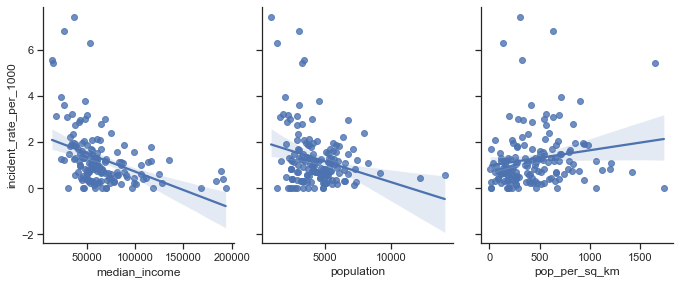

In [195]:
sb.pairplot(choropleth_pop_density, dropna = True, kind = 'reg', y_vars = 'incident_rate_per_1000',\
            x_vars = ('median_income', 'population', 'pop_per_sq_km'), height = 4, aspect = .8, plot_kws={'color':'green'})
sb.pairplot(choropleth_pop_density.drop(choropleth_pop_density[choropleth_pop_density.incident_rate_per_1000 > 20].index),\
            dropna = True, kind = 'reg', y_vars = 'incident_rate_per_1000',\
            x_vars = ('median_income', 'population', 'pop_per_sq_km'), height = 4, aspect = .8);

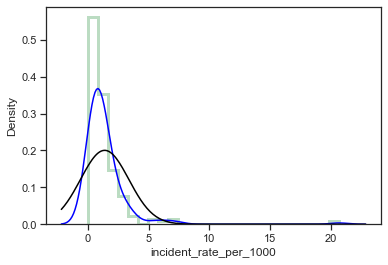

In [158]:
from scipy.stats import norm
sb.distplot(choropleth_pop_density['incident_rate_per_1000'], hist_kws={'histtype':'step', 'color':'g', 'lw':'3'},\
            fit=norm, fit_kws={'color':'black'}, kde=True, bins=25, kde_kws={'color':'blue'});

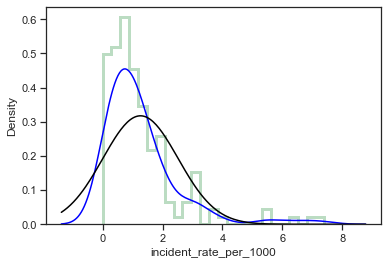

In [159]:
sb.distplot(choropleth_pop_density.drop(choropleth_pop_density[choropleth_pop_density.incident_rate_per_1000 > 20].index)\
            ['incident_rate_per_1000'], hist_kws={'histtype':'step', 'color':'g', 'lw':'3'}, \
            fit=norm, fit_kws={'color':'black'}, kde=True, bins=25, kde_kws={'color':'blue'});

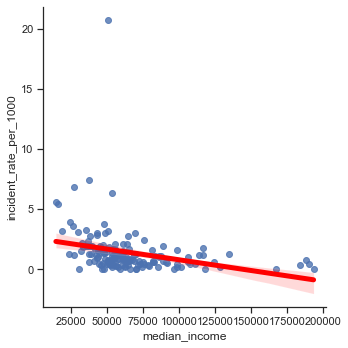

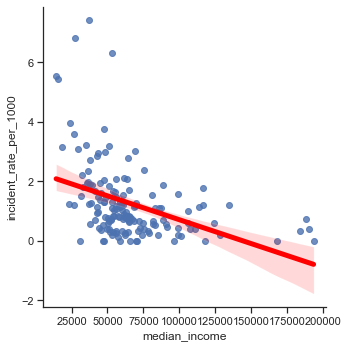

In [204]:
sb.lmplot(data=choropleth_pop_density, x='median_income', y='incident_rate_per_1000', line_kws={'color':'red', 'lw':'5'})
sb.lmplot(data=choropleth_pop_density.drop(choropleth_pop_density[choropleth_pop_density.incident_rate_per_1000 > 20].index), x='median_income', y='incident_rate_per_1000', line_kws={'color':'red', 'lw':'5'});

In [201]:
display(choropleth_pop_density.corr())
display(choropleth_pop_density.drop(choropleth_pop_density[choropleth_pop_density.incident_rate_per_1000 > 20].index).corr())

,population,incident_number,incident_rate_per_1000,median_income,pop_per_sq_km
population,1.000000,0.102772,-0.226161,0.035591,-0.036926
incident_number,0.102772,1.000000,0.881835,-0.304051,0.215283
incident_rate_per_1000,-0.226161,0.881835,1.000000,-0.283425,0.189455
median_income,0.035591,-0.304051,-0.283425,1.000000,-0.323533
pop_per_sq_km,-0.036926,0.215283,0.189455,-0.323533,1.000000


,population,incident_number,incident_rate_per_1000,median_income,pop_per_sq_km
population,1.000000,0.214898,-0.262076,0.032801,-0.028487
incident_number,0.214898,1.000000,0.764981,-0.381380,0.193231
incident_rate_per_1000,-0.262076,0.764981,1.000000,-0.405048,0.166641
median_income,0.032801,-0.381380,-0.405048,1.000000,-0.321660
pop_per_sq_km,-0.028487,0.193231,0.166641,-0.321660,1.000000


In [182]:
sb.lmplot(data=choropleth_pop_density.drop(choropleth_pop_density[choropleth_pop_density.incident_rate_per_1000 > 20].index))

SyntaxError: invalid syntax (Temp/ipykernel_16992/954116448.py, line 1)

In [170]:
choropleth_pop_density.dtypes

tract                       object
population                 float64
incident_number            float64
incident_rate_per_1000     float64
geometry                  geometry
median_income              float64
pop_per_sq_km              float64
dtype: object

In [39]:
folium_data = choropleth_pop_density.copy()
#folium_data['geometry'] = folium_data['geometry'].centroid
folium_data['area'] = folium_data.area

In [40]:
center = folium_data.loc[89, 'geometry'].centroid
center = [center.y, center.x]

In [ ]:
pd.set_option('display.max_rows', None)
print(folium_data.loc[160]['geometry'])

In [41]:
folium_map = folium.Map(location = center, zoom_start = 10.3)
folium.GeoJson(choropleth_pop_density).add_to(folium_map)

for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_37207)
    map_37207.save('../maps/map37207.html')

folium_map

NameError: name 'stops_in_37207' is not defined